# Modelling Afterpay's customer Growth
> How can we model the growth in Afterpay's customer base?

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,Finance]
    
- image: images/2020-04-10-Finding-Vanishing-Points/header.jpg

## The context
Founded in 2014, *Afterpay* is a wildly successful Australian fintech startup. 
With a market capitalisation of circa \$20B AUD (\$14B USD), it has rapidly grown to be a one of Australia's largest companies. In summary, Afterpay let's customers pay for products in 4 separate payments, and charges stores a margin for this. 

I'm interested in applying Bayesian analysis to understand more about Afterpay, based on the information that it has provided to the market, plus a little common sense.

> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.


Now, with that out of the way, let's get started.


## The model

First off, let's load in a bunch of libraries.

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

from io import StringIO
import pandas as pd

import math

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')


While reading through Afterpay's releases to the markets, I cam across this chart, which appears on page 3 of [this](https://www.afterpaytouch.com/images/APT_ASX-Announcement_Q2-FY18_16-Jan-Final-2.pdf) release.


![Image of Afterpay custmer growth](../images/20-08-13-Modelling-Afterpays-Customer-Growth/CustomerGrowth.png)

Now Afterpay launched in the US in mid May of 2018, so we have the opportunity to study how the uptake grew in a new market.



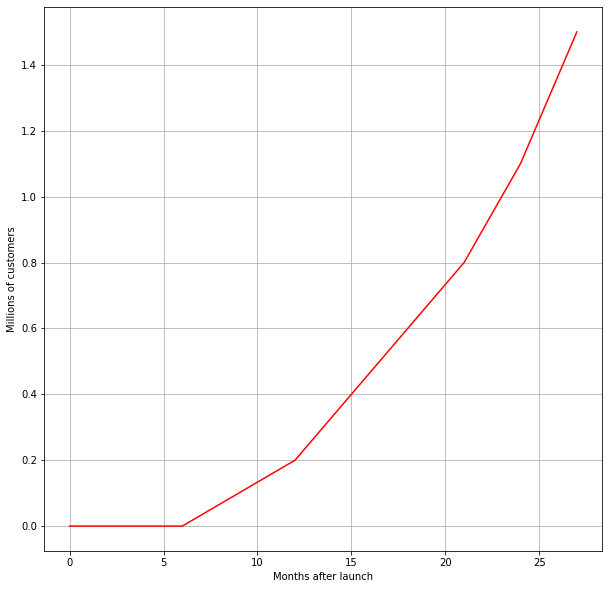

In [11]:
csv_data = StringIO('''millions_customers,date,month_count
            0.0,30-sep-2015,0 
            0.0,31-dec-2015,3 
            0.0,31-mar-2016,6 
            0.1,30-jun-2016,9 
            0.2,30-sep-2016,12
            0.4,31-dec-2016,15
            0.6,31-mar-2017,18
            0.8,30-jun-2017,21
            1.1,30-sep-2017,24
            1.5,31-dec-2017,27''')


df = pd.read_csv(csv_data, sep=",")
plt.plot(df.month_count,df.millions_customers,color='r')
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.grid()
plt.show()

From this, we can see a rapid, accelerating growth in the number of customers over time. 

One model we could use is the [sigmoidal model](https://www.sciencedirect.com/science/article/pii/S1877705811001597/pdf?md5=a6adf115754239aeb12922ec06a20a9e&pid=1-s2.0-S1877705811001597-main.pdf). Also known as "The *S* shaped curve", it's a model where growth starts off slow, accelerates, before slowing again. It's often used in technology adoption, or the introduction of a new product.

$$\frac{1}{1+e^{-x}}$$


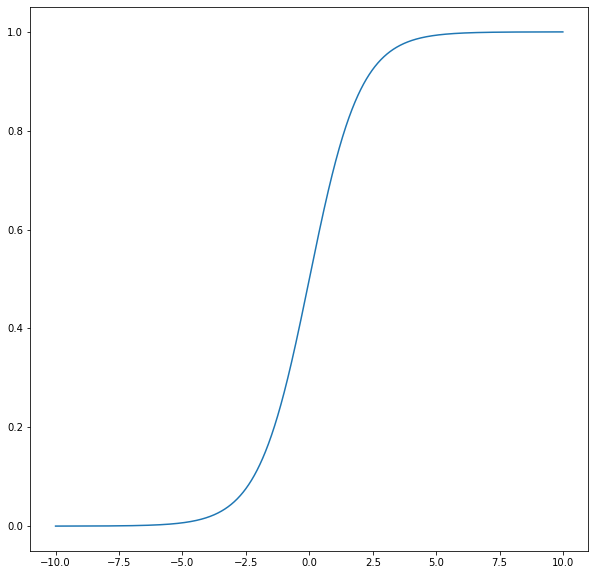

In [15]:
x = np.arange(-10,10,0.01)
y = 1/(1+math.e**-x)
plt.plot(x,y,color='k')
plt.grid()
plt.show()

The model can be modified, to modify the scale (*L*), how fast it grows (*k*), or when the fastest growth occurs (*x0*).

$$\frac{L}{1+e^{-k(x-x0)}}$$

We can fit this model, to the data provided by Afterpay using PyMC3.

We can also utilise priors, to inject things we might know or suspect. 

For example, while I am open minded about what proportion of Australians may choose to become customers of Afterpay, I limit the model to a maximum of 25M customers (population of Australia).

In general, this isn't great practice, because I explicitly exclude the possibility that there could be more than 25M customers, and no amount of data will be able to change my mind.

To quote Cromwell : *I beseech you, in the bowels of Christ, think it possible that you may be mistaken.*

Let's compose this as a Bayesian Regression problem.

In [3]:
with pm.Model() as model:
    millions_customers = df.millions_customers.values
    x = df.month_count.values.astype(np.float64)
    L =  pm.Uniform('L', lower = 0, upper = 25) 
    k =  pm.Uniform('k', lower=0, upper=1) 
    x0 = pm.Uniform('x0', lower=0, upper=100) 
    
    customers_predicted = L/(1+math.e**(-k*(x-x0)))
    customers = pm.Normal('customers', mu = customers_predicted, sigma = 0.1, observed = millions_customers)
    

In [4]:
with model:
    trace = pm.sample(draws=10_000,tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x0, k, L]
Sampling 2 chains, 1 divergences: 100%|██████████| 30000/30000 [01:19<00:00, 377.74draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


## The Results

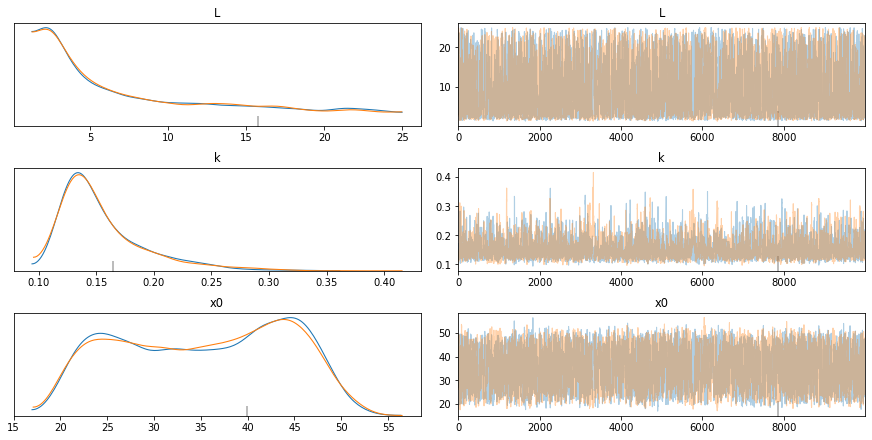

In [5]:
pm.traceplot(trace);

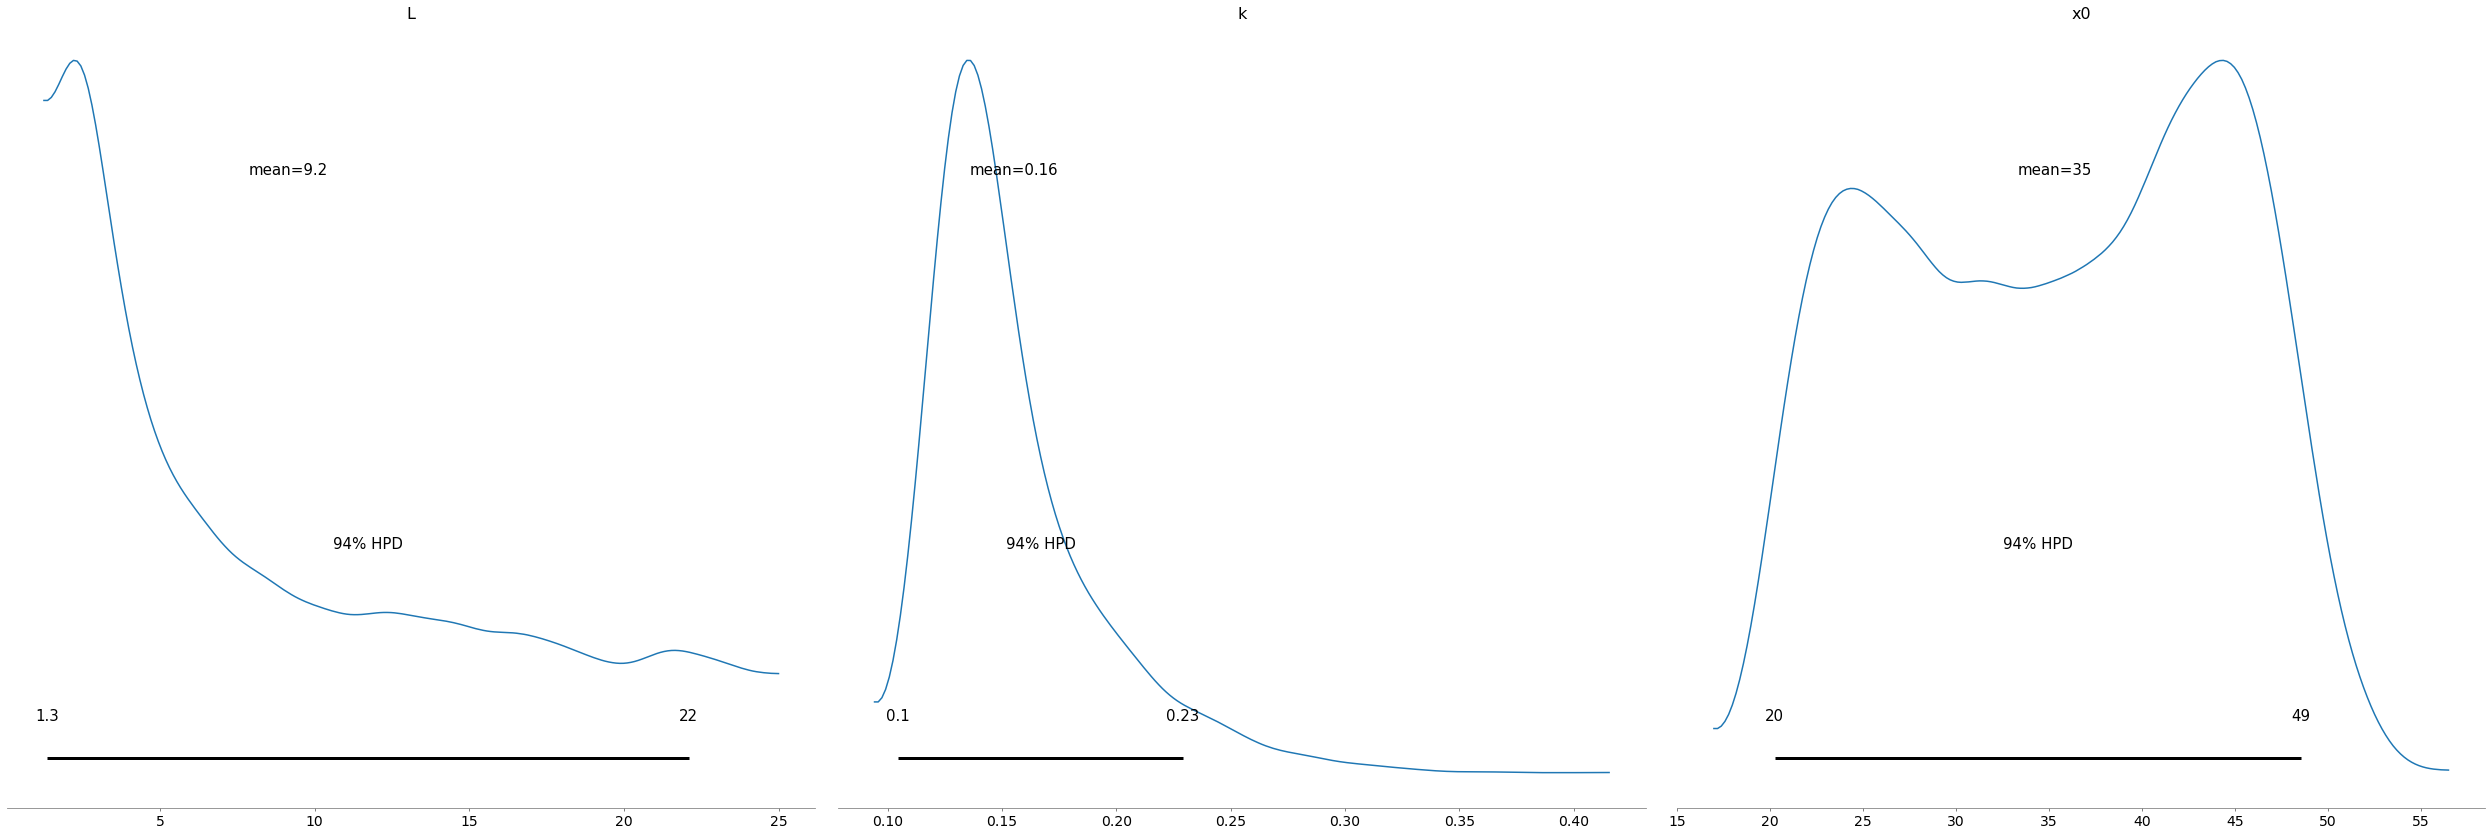

In [6]:
pm.plot_posterior(trace);

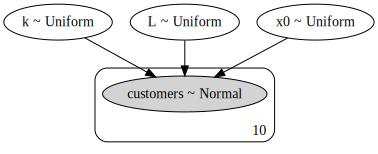

In [7]:
pm.model_to_graphviz(model)

In [8]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
L,9.158,6.862,1.342,22.088,0.134,0.095,2631.0,2631.0,2380.0,3781.0,1.0
k,0.155,0.037,0.105,0.229,0.001,0.001,2267.0,2231.0,2657.0,2890.0,1.0
x0,35.293,8.826,20.244,48.540,0.180,0.127,2406.0,2406.0,2427.0,3771.0,1.0


## Posterior Predictive Checks
Let's see if our model makes sense. By drawing samples from our model, we can further investigate the potential growth rates of Afterpay. 

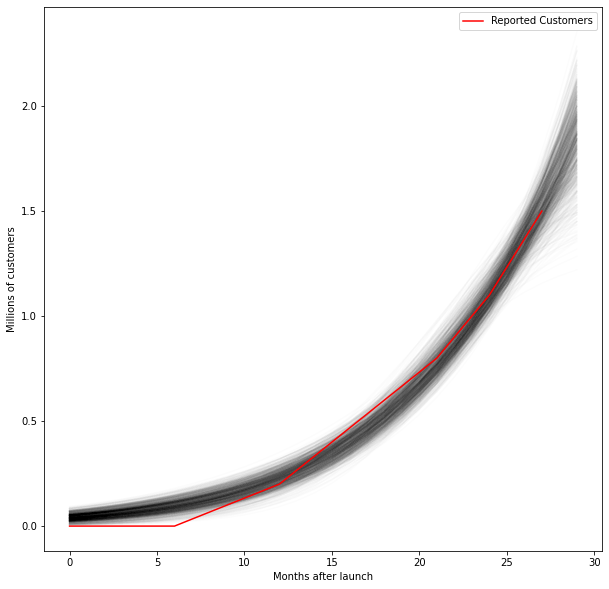

In [9]:
for i in range(0,1_000):
    x = np.arange(0,30)
    plt.plot(x,trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i]))),color='k',alpha=0.01)
plt.plot(df.month_count,df.millions_customers,color='r',label='Reported Customers')

plt.legend()
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.show()

Now let's start forcasting into the future. We can compare what we modelled to the actual customer numbers (3.1M) reported by Afterpay 54 months after they first launched.


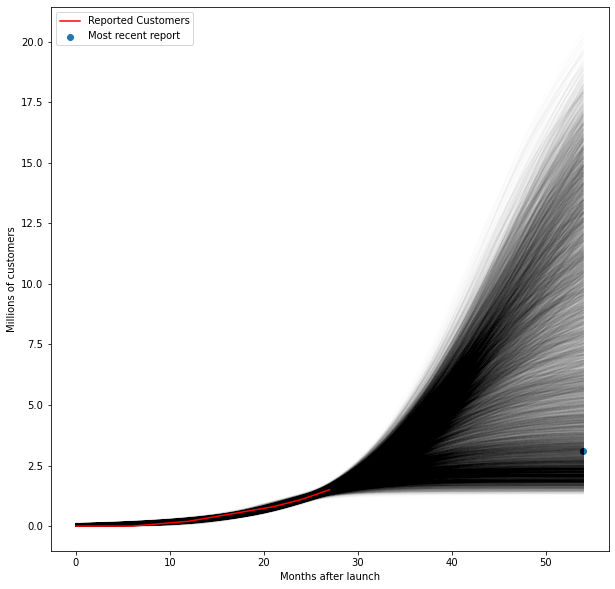

In [16]:
for i in range(0,10_000):
    x = np.arange(0,55)
    plt.plot(x,trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i]))),color='k',alpha=0.01)
plt.plot(df.month_count,df.millions_customers,color='r',label='Reported Customers')


plt.scatter(54,3.1,label='Most recent report')
plt.legend()

plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.show()

We can also generate a histogram, and compare the predictions of our model with the actual true number of 3.1M.

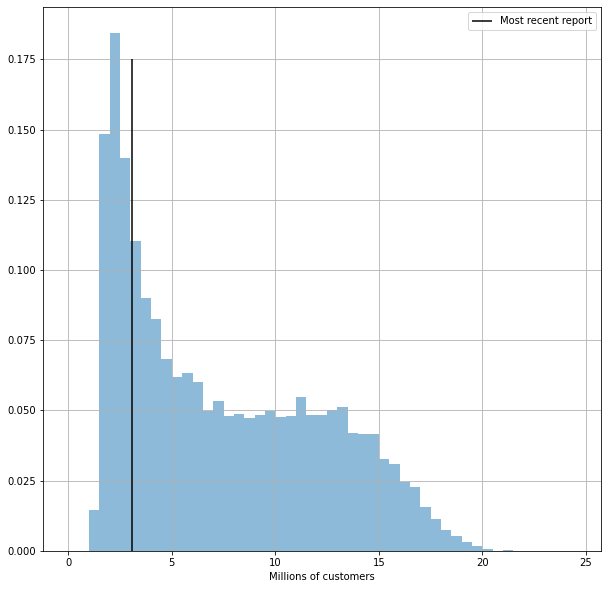

In [43]:
x = 54*np.ones(20000)
y = trace['L']/(1+math.e**(-trace['k']*(x-trace['x0'])))                              
plt.hist(y,bins=np.arange(0,25,0.5),alpha=0.5,density=True)
plt.vlines(3.1,0,0.175,label='Most recent report')
        
plt.xlabel('Millions of customers')
plt.legend()
plt.grid()
plt.show()

## Conclusion
In Conclusion, Bayesian analysis is a powerful tool, because it allows us to understand how confident we are in our predictions. It's also powerful because we can feed in information that we might already believe. If you are 80% confident that no more than 20% of the Australian population will use Afterpay, then you can feed this in as a prior. 

While this is a fairly *rough and ready* model, I'm going to continue analysing *Afterpay*. My end-game is to try and gain an understanding of their default rates. It's an area 
